In [1]:
import os
import cv2
import random
import numpy as np
import skimage
import umap   #!pip install umap-learn hdbscan transformers
import hdbscan
import pandas as pd
import torch

from glob import glob
from collections import Counter
from tqdm.auto import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
BATCH_SIZE = 16
SEED = 42

CLIP 모델과 UMAP을 통한 이미지 클러스터링 하기

In [3]:
# https://huggingface.co/geolocal/StreetCLIP
# StreetCLIP is a robust foundation model for open-domain image geolocalization and other geographic and climate-related tasks.

clip_model = CLIPModel.from_pretrained("geolocal/StreetCLIP") #Hugging Face에서 모델로드
clip_model.to('cuda')
clip_processor = CLIPProcessor.from_pretrained("geolocal/StreetCLIP")

In [4]:
image_paths = sorted(glob('./train_gt/*.png'))


In [5]:
image_features = []
for i in tqdm(range(0,len(image_paths), BATCH_SIZE)):
    image_paths_batch = image_paths[i:i+BATCH_SIZE]
    images = [Image.open(image_path) for image_path in image_paths_batch]
    pixel_values = clip_processor.image_processor(images=images, return_tensors='pt')['pixel_values'].to('cuda')
    with torch.no_grad():
        image_features_row = clip_model.get_image_features(pixel_values).cpu().numpy()
    image_features.append(image_features_row)

  0%|          | 0/1851 [00:00<?, ?it/s]

In [6]:
train_embeddings = np.vstack(image_features)

In [7]:
train_embeddings = normalize(train_embeddings, norm="l2")

In [8]:
np.save('./preproc/train_embeddings', train_embeddings)
# train_embeddings = np.load('./preproc/train_embeddings.npy')

UMAP을 통해 이미지 임베딩을 클러스터링하기

In [9]:
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=2,
    random_state=SEED,
).fit_transform(train_embeddings)

/home/kwy00/anaconda3/envs/test/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


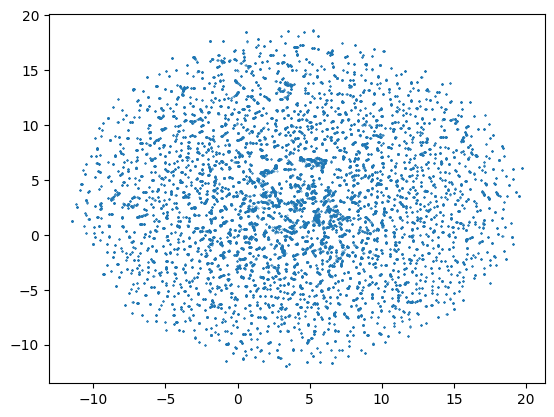

In [10]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1)

In [11]:
labels = hdbscan.HDBSCAN(
    min_cluster_size=5,
).fit_predict(clusterable_embedding)

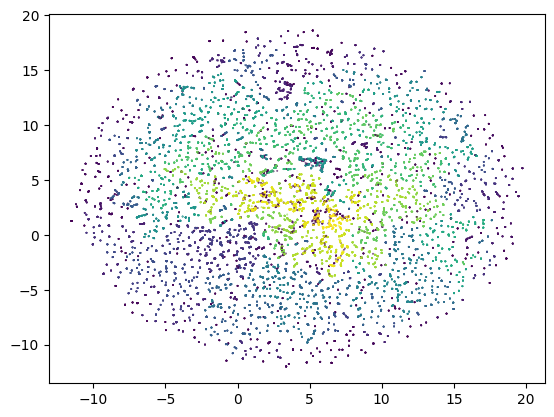

In [12]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=labels, s=0.1)

In [13]:
len(set(labels)), sum(labels==-1)

(2456, 2162)

In [14]:
counter = Counter([label for label in labels if label!=-1])

In [15]:
min(counter.values()), np.median(list(counter.values())), max(counter.values())

(5, 10.0, 64)

클러스터 별 이미지 확인 및 저장하기


label is 0


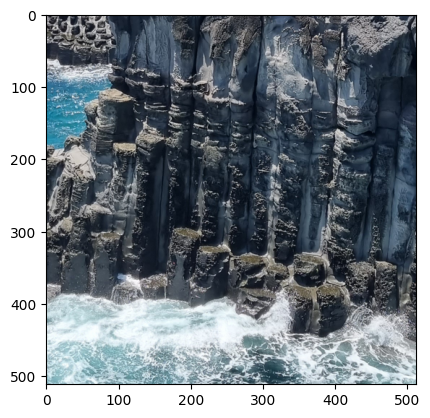

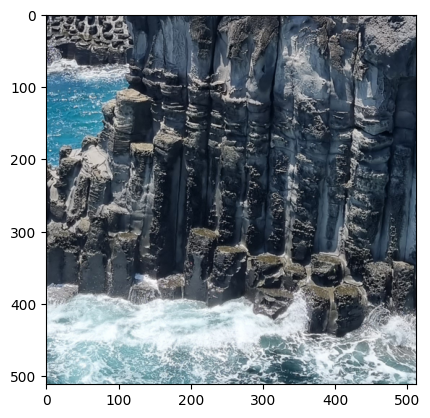

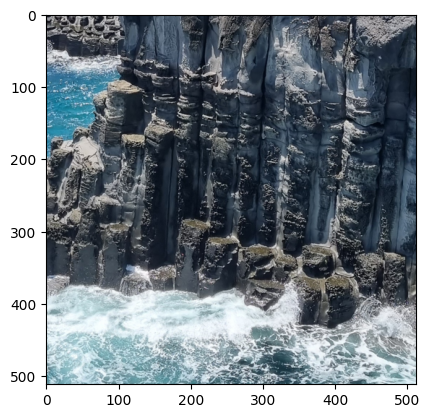

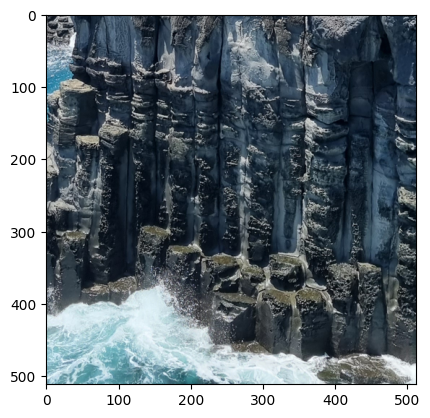

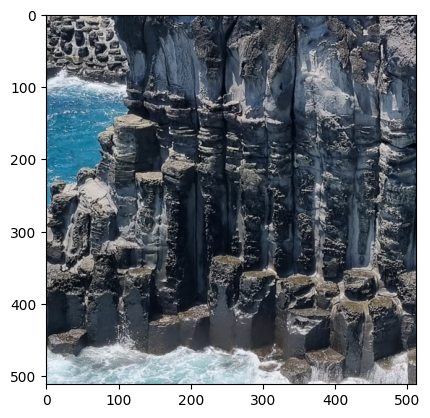

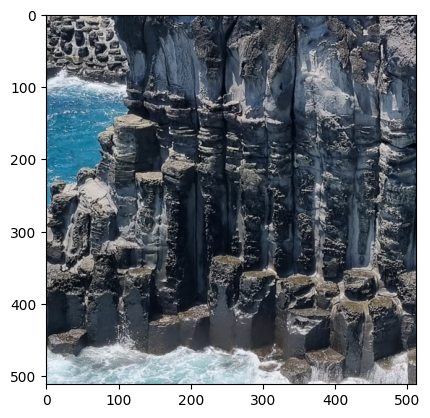

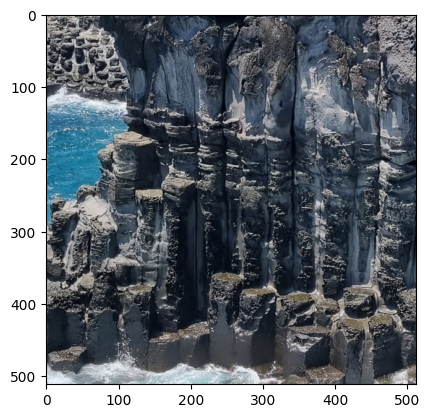

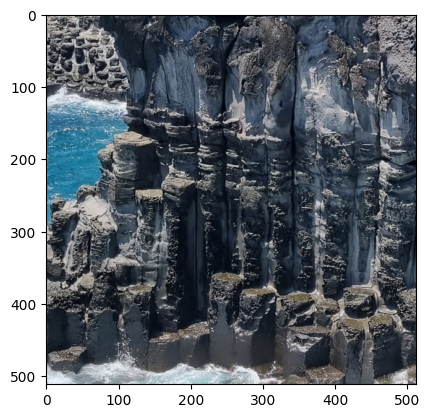

label is 1


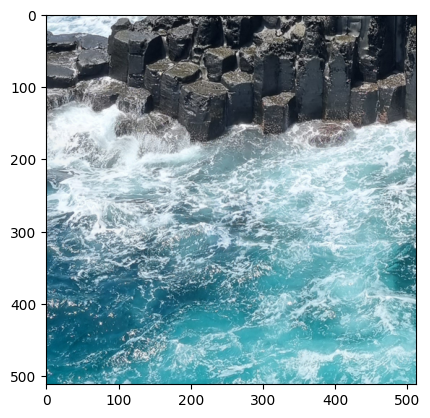

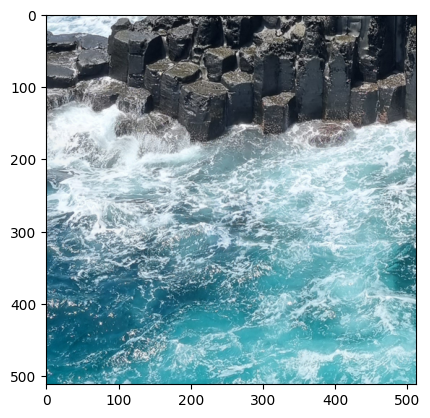

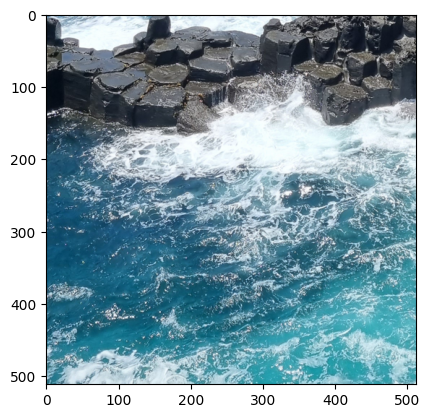

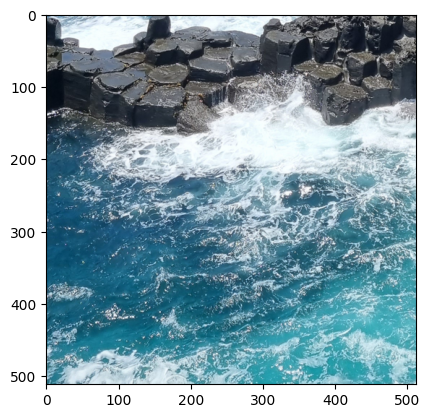

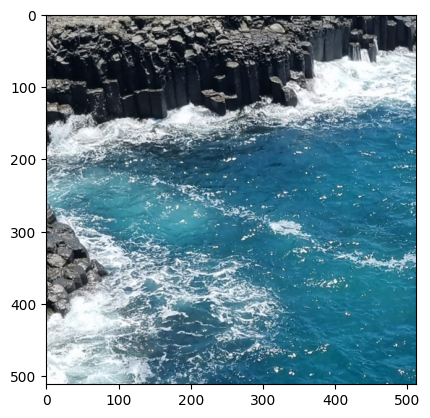

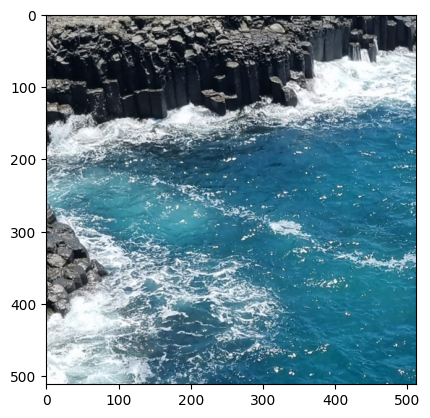

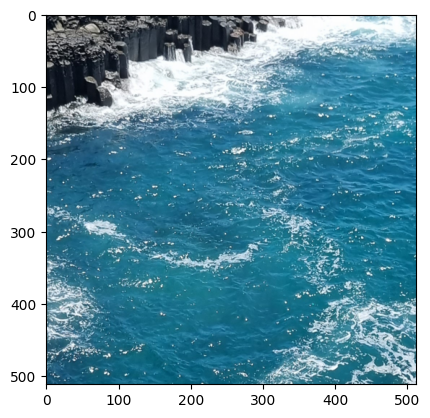

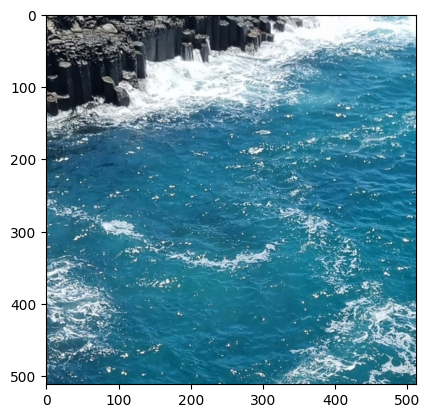

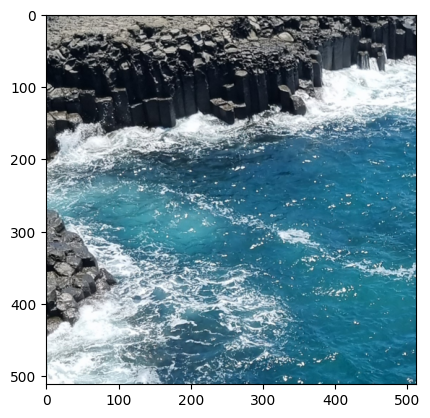

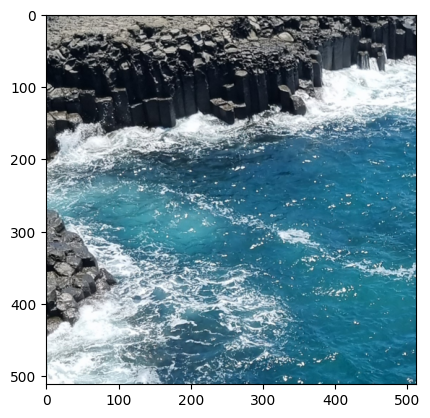

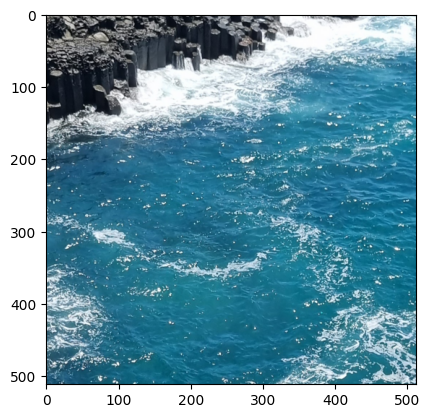

In [16]:
print('label is 0')
for image_path in np.array(image_paths)[labels==0]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
print('label is 1')
for image_path in np.array(image_paths)[labels==1]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()

In [17]:
train_df = pd.DataFrame(columns=['image','label'])

In [18]:
train_df['image'] = [os.path.basename(image_path) for image_path in image_paths]
train_df['label'] = labels

In [19]:
train_df.to_csv('./preproc/train_preproc.csv', index=False)

In [20]:
test_image_paths = sorted(glob('./test_input//*.png'))

In [21]:
test_df = pd.DataFrame(columns=['image'])

In [22]:
test_df['image'] = [os.path.basename(image_path) for image_path in test_image_paths]

In [23]:
test_df.to_csv('./preproc/test_preproc.csv', index=False)

2. 모델 학습 코드

    라이브러리 인스톨

In [24]:
import os
import math
import random
import zipfile
import cv2
import numpy as np
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L    #!pip install polygenerator lightning segmentation-models-pytorch
import segmentation_models_pytorch as smp

from tqdm.auto import tqdm
from glob import glob
from PIL import Image
from polygenerator import (
    random_polygon,
    random_star_shaped_polygon,
    random_convex_polygon,
)
from sklearn.model_selection import KFold
from skimage.metrics import structural_similarity as ski_ssim
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from matplotlib import pyplot as plt

In [25]:
torch.set_float32_matmul_precision('medium')

In [26]:
def get_input_image(image, min_polygon_bbox_size=50):
    width, height = image.size
    while True:
        bbox_x1 = random.randint(0, width-min_polygon_bbox_size)
        bbox_y1 = random.randint(0, height-min_polygon_bbox_size)
        bbox_x2 = random.randint(bbox_x1, width)  # Ensure width > 10
        bbox_y2 = random.randint(bbox_y1, height)  # Ensure height > 10
        if (bbox_x2-bbox_x1)<min_polygon_bbox_size or (bbox_y2-bbox_y1)<min_polygon_bbox_size:
            continue
        
        mask_bbox = [bbox_x1, bbox_y1, bbox_x2, bbox_y2]
        mask_width = bbox_x2-bbox_x1
        mask_height = bbox_y2-bbox_y1
    
        num_points = random.randint(3,20)
        polygon_func = random.choice([
            random_polygon,
            random_star_shaped_polygon,
            random_convex_polygon
        ])
        polygon = polygon_func(num_points=num_points) #scaled 0~1
        polygon = [(round(r*mask_width), round(c*mask_height)) for r,c in polygon]
        polygon_mask = skimage.draw.polygon2mask((mask_width, mask_height), polygon)
        if np.sum(polygon_mask)>(min_polygon_bbox_size//2)**2:
            break
    full_image_mask = np.zeros((width, height), dtype=np.uint8)
    full_image_mask[bbox_x1:bbox_x2, bbox_y1:bbox_y2] = polygon_mask
    
    image_gray = image.convert('L')
    image_gray_array = np.array(image_gray)  # Convert to numpy array for manipulation
    random_color = random.randint(0, 255)  # Random grayscale color
    image_gray_array[full_image_mask == 1] = random_color
    image_gray_masked = Image.fromarray(image_gray_array)

    return {
        'image_gt':image,
        'mask':full_image_mask,
        'image_gray':image_gray,
        'image_gray_masked':image_gray_masked
    }

In [27]:
def get_ssim_score(true, pred):
    # 전체 RGB 이미지를 사용해 SSIM 계산 (channel_axis=-1)
    ssim_value = ski_ssim(true, pred, channel_axis=-1, data_range=pred.max() - pred.min())
    return ssim_value

def get_masked_ssim_score(true, pred, mask):
    # 손실 영역의 좌표에서만 RGB 채널별 픽셀 값 추출
    true_masked_pixels = true[mask > 0]
    pred_masked_pixels = pred[mask > 0]
    
    # 손실 영역 픽셀만으로 SSIM 계산 (채널축 사용)
    ssim_value = ski_ssim(
        true_masked_pixels, 
        pred_masked_pixels, 
        channel_axis=-1, 
        data_range=pred.max() - pred.min()
    )
    return ssim_value

def get_histogram_similarity(true, pred, cvt_color=cv2.COLOR_RGB2HSV):
    # BGR 이미지를 HSV로 변환
    true_hsv = cv2.cvtColor(true, cvt_color)
    pred_hsv = cv2.cvtColor(pred, cvt_color)

    # H 채널에서 히스토그램 계산 및 정규화
    hist_true = cv2.calcHist([true_hsv], [0], None, [180], [0, 180])
    hist_pred = cv2.calcHist([pred_hsv], [0], None, [180], [0, 180])
    hist_true = cv2.normalize(hist_true, hist_true).flatten()
    hist_pred = cv2.normalize(hist_pred, hist_pred).flatten()

    # 히스토그램 간 유사도 계산 (상관 계수 사용)
    similarity = cv2.compareHist(hist_true, hist_pred, cv2.HISTCMP_CORREL)
    return similarity

하이퍼 파라미터 설정, 데이터 로드 및 전처리

In [28]:
SEED=42
N_SPLIT=5
BATCH_SIZE=8
IMAGE_PREPROC_MEAN=0.5
IMAGE_PREPROC_STD=0.225
MIN_POLYGON_BBOX_SIZE = 50

In [29]:
TRAIN_DATA_DIR='./train_gt'
VALID_DATA_DIR=f'./valid_input/{SEED=}-{MIN_POLYGON_BBOX_SIZE=}'
TEST_DATA_DIR='./test_input'
SUBMISSON_DATA_DIR='./submission'
EXPERIMENT_NAME='baseline'

In [30]:
L.seed_everything(SEED)

Seed set to 42


42

In [31]:
train_df = pd.read_csv('./preproc/train_preproc.csv')
test_df = pd.read_csv('./preproc/test_preproc.csv')

In [32]:
os.makedirs(VALID_DATA_DIR, exist_ok=True)
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = train_df.iloc[idx, 0]
    img_path = os.path.join(TRAIN_DATA_DIR, img_path)
    save_image_name = os.path.basename(img_path).replace('TRAIN', 'VALID').replace('png','npy')
    save_image_path = f'{VALID_DATA_DIR}/{save_image_name}'
    if os.path.exists(save_image_path):
        continue
    image = Image.open(img_path)
    valid_input_image = get_input_image(image, MIN_POLYGON_BBOX_SIZE)
    np.save(save_image_path, valid_input_image)

  0%|          | 0/29603 [00:00<?, ?it/s]

In [33]:
train_df_outlier = train_df[train_df['label']==-1]
train_df = train_df[train_df['label']!=-1]

In [34]:
kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=SEED)

In [35]:
for fold_idx, (train_indices, valid_indices) in enumerate(kf.split(train_df['image'], train_df['label'])):
    train_fold_df = train_df.iloc[train_indices].reset_index(drop=True)
    valid_fold_df = train_df.iloc[valid_indices].reset_index(drop=True)
    valid_fold_df['image'] = valid_fold_df['image'].apply(lambda x: x.replace('TRAIN', 'VALID').replace('png', 'npy'))
    valid_fold_df = valid_fold_df.drop_duplicates('label') # for fast validation
    # train_fold_df = pd.concat([train_fold_df,train_df_outlier],axis=0).reset_index(drop=True)
    break

데이터셋 클래스 작성 및 초기화

In [36]:
class CustomImageDataset(Dataset):
    def __init__(self, df, data_dir='./data/train_gt', mode='train', min_polygon_bbox_size=MIN_POLYGON_BBOX_SIZE):
        self.df = df
        self.data_dir = data_dir
        self.mode = mode
        self.min_polygon_bbox_size = min_polygon_bbox_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.df.iloc[idx, 0]  # Assuming first column is the path
        img_path = os.path.join(self.data_dir, img_path)
        
        # Apply augmentation if in training mode
        if self.mode == 'train':
            image = Image.open(img_path)
            image_input = get_input_image(image, self.min_polygon_bbox_size)
            return image_input

        elif self.mode == 'valid':
            image_input = self.load_input_image(img_path)
            return image_input
        elif self.mode == 'test':
            image = Image.open(img_path)
            return {
                'image_gray_masked':image
            }

    def load_input_image(self, img_input_path):
        image_input = np.load(img_input_path, allow_pickle=True)
        return image_input.item()
    

In [37]:
train_dataset = CustomImageDataset(train_fold_df, data_dir=TRAIN_DATA_DIR, mode='train')
valid_dataset = CustomImageDataset(valid_fold_df, data_dir=VALID_DATA_DIR, mode='valid')
test_dataset = CustomImageDataset(test_df, data_dir=TEST_DATA_DIR, mode='test')

데이터 시각화

In [38]:
for idx, data in tqdm(enumerate(valid_dataset)):
    break

0it [00:00, ?it/s]

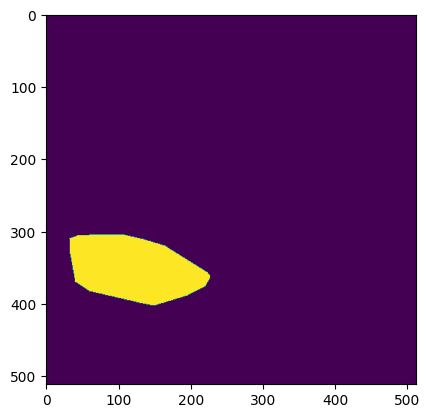

In [39]:
plt.imshow(data['mask'])

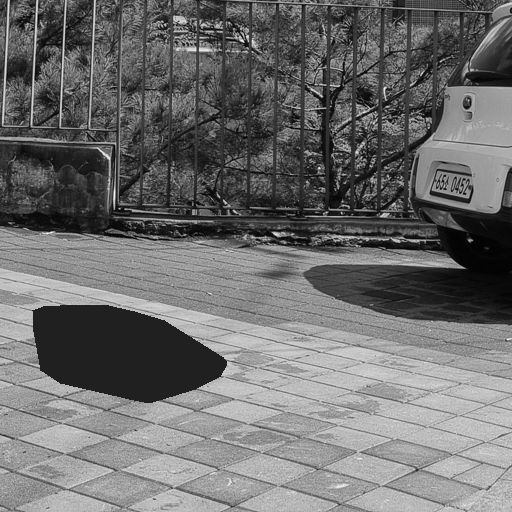

In [40]:
data['image_gray_masked']

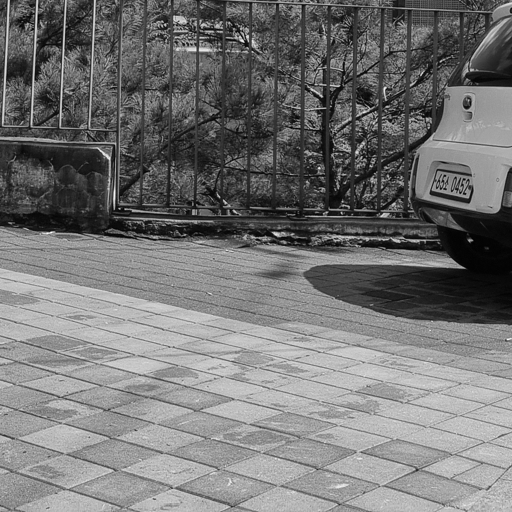

In [41]:
data['image_gray']

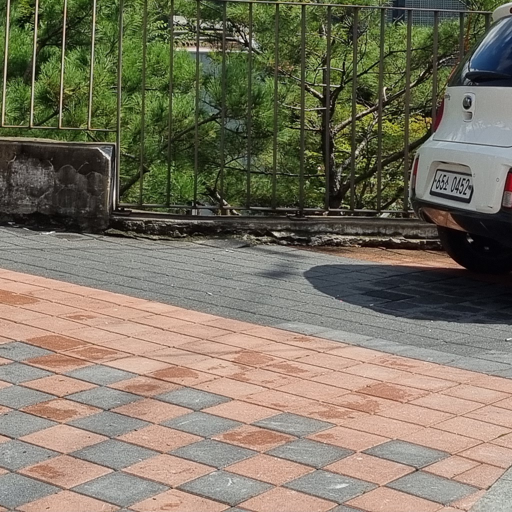

In [42]:
data['image_gt']

데이터로더 작성 및 초기화

In [43]:
class CollateFn:
    def __init__(self, mean=IMAGE_PREPROC_MEAN, std=IMAGE_PREPROC_STD, mode='train'):
        self.mode = mode
        self.mean = mean
        self.std = std

    def __call__(self, examples):
        if self.mode =='train' or self.mode=='valid':
            # Initialize lists to store each component of the batch
            masks= []
            images_gray = []
            images_gray_masked = []
            images_gt = []
    
            for example in examples:
                # Assuming each example is a dictionary with keys 'mask', 'image_gray', 'image_gray_masked', 'image_gt'
                masks.append(example['mask'])
                images_gray.append(self.normalize_image(example['image_gray']))
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
                images_gt.append(self.normalize_image(np.array(example['image_gt'])))

            return {
                'masks': torch.from_numpy(np.stack(masks)).long(),
                'images_gray': torch.from_numpy(np.stack(images_gray)).unsqueeze(1).float(),
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
                'images_gt': torch.from_numpy(np.stack(images_gt)).permute(0,3,1,2).float()
            }

        elif self.mode == 'test':
            images_gray_masked = []
            for example in examples:
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
            return {
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
            }

    def normalize_image(self, image):
        return (np.array(image)/255-self.mean)/self.std

In [44]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=CollateFn(mode='train'),num_workers=64)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=CollateFn(mode='valid'),num_workers=64)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=CollateFn(mode='test'))

/home/kwy00/anaconda3/envs/test/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


모델 작성 및 초기화

In [45]:
class LitIRModel(L.LightningModule):
    def __init__(self, model_1, model_2, image_mean=IMAGE_PREPROC_MEAN, image_std=IMAGE_PREPROC_STD):
        super().__init__()
        self.model_1 = model_1
        self.model_2 = model_2
        self.image_mean=image_mean
        self.image_std=image_std

    def forward(self, images_gray_masked):
        images_gray_restored = self.model_1(images_gray_masked)+images_gray_masked
        images_restored = self.model_2(images_gray_restored)
        return images_gray_restored, images_restored
        
    def unnormalize(self, output, round=False):
        image_restored = ((output*self.image_std+self.image_mean)*255).clamp(0,255)
        if round:
            image_restored = torch.round(image_restored)
        return image_restored
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=1e-5)
        return opt

    def training_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gray, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gray'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)
        
        loss_pixel_gray = F.l1_loss(images_gray, images_gray_restored, reduction='mean') * 0.5 + F.mse_loss(images_gray, images_gray_restored, reduction='mean') * 0.5
        loss_pixel = F.l1_loss(images_gt, images_restored, reduction='mean') * 0.5 + F.mse_loss(images_gt, images_restored, reduction='mean') * 0.5
        loss = loss_pixel_gray * 0.5 + loss_pixel * 0.5

        self.log("train_loss", loss, on_step=True, on_epoch=False)
        self.log("train_loss_pixel_gray", loss_pixel_gray, on_step=True, on_epoch=False)
        self.log("train_loss_pixel", loss_pixel, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_gt, images_restored = self.unnormalize(images_gt, round=True), self.unnormalize(images_restored, round=True)
        masks_np = masks.detach().cpu().numpy()
        images_gt_np = images_gt.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        total_ssim_score = 0
        masked_ssim_score = 0
        hist_sim_score = 0
        for image_gt_np, image_restored_np, mask_np in zip(images_gt_np, images_restored_np, masks_np):
            total_ssim_score += get_ssim_score(image_gt_np, image_restored_np) / len(images_gt)
            masked_ssim_score += get_masked_ssim_score(image_gt_np, image_restored_np, mask_np)/ len(images_gt)
            hist_sim_score += get_histogram_similarity(image_gt_np, image_restored_np, cv2.COLOR_RGB2HSV)/ len(images_gt)
        score = total_ssim_score * 0.2 + masked_ssim_score * 0.4 + hist_sim_score * 0.4
        self.log(f"val_score", score, on_step=False, on_epoch=True)
        self.log(f"val_total_ssim_score", total_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_masked_ssim_score", masked_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_hist_sim_score", hist_sim_score, on_step=False, on_epoch=True)
        return score

    def predict_step(self, batch, batch_idx):
        images_gray_masked = batch['images_gray_masked']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_restored = self.unnormalize(images_restored, round=True)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        return images_restored_np


In [46]:
# 다른모델 사용
# https://smp.readthedocs.io/en/latest/encoders.html

# gray mask restoration
model_1 = smp.PSPNet(
    encoder_name="resnet50",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=1,                      
)

# gray -> color
model_2 = smp.PSPNet(
    encoder_name="resnet50",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=3,                      
)
'''
# GPU가 2개 이상 사용 가능한지 확인
if torch.cuda.device_count() >= 2:
    device_0 = torch.device("cuda:0")
    device_1 = torch.device("cuda:1")
    
    # 각각의 모델을 다른 GPU에 할당
    model_1 = model_1.to(device_0)
    model_2 = model_2.to(device_1)
    
    # DataParallel을 사용하여 모델 병렬 처리 (모든 GPU 사용)
    model_1 = torch.nn.DataParallel(model_1)
    model_2 = torch.nn.DataParallel(model_2)
else:
    raise ValueError("2개 이상의 GPU가 필요합니다.")
'''

lit_ir_model = LitIRModel(model_1=nn.DataParallel(model_1), model_2=nn.DataParallel(model_2))

모델 학습

In [47]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_score',
    mode='max',
    dirpath='./checkpoint/',
    filename=f'smp-unet-resnet34-{fold_idx=}-{SEED=}'+'-{epoch:02d}-{val_score:.4f}',
    save_top_k=1,
    save_weights_only=True,
    verbose=True
)
earlystopping_callback = EarlyStopping(monitor="val_score", mode="max", patience=3)

In [48]:
trainer = L.Trainer(max_epochs=100, precision='bf16-mixed', callbacks=[checkpoint_callback, earlystopping_callback], detect_anomaly=False)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(lit_ir_model, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model_1 | DataParallel | 24.3 M | train
1 | model_2 | DataParallel | 24.3 M | train
-------------------------------------------------
48.6 M    Trainable params
0         Non-trainable params
48.6 M    Total params
194.395   Total estimated model params size (MB)
384       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 2744: 'val_score' reached 0.29539 (best 0.29539), saving model to '/home/kwy00/DACON/restore_image/checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=00-val_score=0.2954.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 5488: 'val_score' reached 0.32958 (best 0.32958), saving model to '/home/kwy00/DACON/restore_image/checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=01-val_score=0.3296.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 8232: 'val_score' reached 0.35098 (best 0.35098), saving model to '/home/kwy00/DACON/restore_image/checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=02-val_score=0.3510.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 10976: 'val_score' reached 0.35246 (best 0.35246), saving model to '/home/kwy00/DACON/restore_image/checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=03-val_score=0.3525.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 13720: 'val_score' reached 0.36595 (best 0.36595), saving model to '/home/kwy00/DACON/restore_image/checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=04-val_score=0.3660.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 16464: 'val_score' reached 0.37100 (best 0.37100), saving model to '/home/kwy00/DACON/restore_image/checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=05-val_score=0.3710.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 19208: 'val_score' reached 0.37880 (best 0.37880), saving model to '/home/kwy00/DACON/restore_image/checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=06-val_score=0.3788.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 21952: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 24696: 'val_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 27440: 'val_score' reached 0.38260 (best 0.38260), saving model to '/home/kwy00/DACON/restore_image/checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=09-val_score=0.3826.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 30184: 'val_score' reached 0.38821 (best 0.38821), saving model to '/home/kwy00/DACON/restore_image/checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=10-val_score=0.3882.ckpt' as top 1


In [ ]:
'''
lit_ir_model = LitIRModel.load_from_checkpoint(
    './checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=43-val_score=0.6260.ckpt',
    model_1=model_1,
    model_2=model_2,
    strict=True
)
'''

"\nlit_ir_model = LitIRModel.load_from_checkpoint(\n    './checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=43-val_score=0.6260.ckpt',\n    model_1=model_1,\n    model_2=model_2,\n    strict=True\n)\n"

In [ ]:
# 체크포인트 로드
checkpoint = torch.load('./checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=43-val_score=0.6260.ckpt')

# 키 수정
state_dict = checkpoint['state_dict']
new_state_dict = {key.replace('module.', ''): value for key, value in state_dict.items()}

# 수정된 체크포인트 저장
checkpoint['state_dict'] = new_state_dict
torch.save(checkpoint, './checkpoint/modified_checkpoint.ckpt')

# 수정된 체크포인트 로드
lit_ir_model = LitIRModel.load_from_checkpoint(
    './checkpoint/modified_checkpoint.ckpt',
    model_1=model_1,
    model_2=model_2
)


/tmp/ipykernel_574051/3134381176.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=43-val_

FileNotFoundError: [Errno 2] No such file or directory: './checkpoint/smp-unet-resnet34-fold_idx=0-SEED=42-epoch=43-val_score=0.6260.ckpt'

In [ ]:
predictions = trainer.predict(lit_ir_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
predictions = np.concatenate(predictions)

In [ ]:
submission_dir = os.path.join(SUBMISSON_DATA_DIR, EXPERIMENT_NAME)
submission_file = f'{SUBMISSON_DATA_DIR}/{EXPERIMENT_NAME}.zip'
os.makedirs(submission_dir, exist_ok=True)

In [ ]:
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    image_pred = Image.fromarray(predictions[idx])
    image_pred.save(os.path.join(submission_dir, row['image']), "PNG")

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
 # Step 3: Compress the directory into a ZIP file using glob
with zipfile.ZipFile(submission_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file_path in glob(f"{submission_dir}/*.png"):
        arcname = os.path.relpath(file_path, submission_dir)
        zipf.write(file_path, arcname)